In [ ]:
#  اگر از کولب استفاده نمیکنید این بخش را کامنت کنید


from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/MyDrive/51gan

Mounted at /content/drive
/content/drive/MyDrive/51gan


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 17 16:14:40 2022

@author: Mohammadreza

"""

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from sys import exit
import pathlib



In [ ]:

# Set random seed for reproducibility
manualSeed = 9990
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size =32 # 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.

# image_size = 512 # 64
image_size = 128
# Number of channels in the training images. For color images this is 3
nc = 1 #**************

# Size of z latent vector (i.e. size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 16 #64--> ngf/4=64/4=16

# Number of training epochs
num_epochs = 50  #10

# Learning rate for optimizers
lr_G = 0.0002
lr_D = 0.0002 # lr_D > lr_G

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# add noise to discriminator
AddNoiseToD = True
STD_ini = 0.9

#Evaluation phase
EvaluationPhase = False
epoch_no = 43

# -----------------------------------
datafolderName = os.path.basename(dataroot)
chkPath_netG =  f'./_results/{datafolderName}_ckp/netG_{datafolderName}_epoch{epoch_no}.pt'
pathlib.Path(f'./_results/{datafolderName}_ckp').mkdir(parents=True, exist_ok=True) 
# -----------------------------------


Random Seed:  9990


In [ ]:

# We can use an image folder dataset the way we have it setup.
# Create the dataset
if nc==3:   #RGB image
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize [0,1] to [-1,1]
                               ]))
else: #gray-scale image, nc=1
    # convert to gray scale
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.RandomApply([transforms.RandomResizedCrop(size=image_size, scale=(0.5,1)),
                                                           transforms.RandomHorizontalFlip(p=0.5),
                                                           transforms.RandomVerticalFlip(p=0.5)],
                                                           p=0.5),
                                   transforms.ToTensor(),  
                                   transforms.Normalize((0.5), (0.5)), # normalize [0,1] to [-1,1], [mean,STD]                      
                               ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
real_batch,labels = next(iter(dataloader))
print('real_batch size is: ',real_batch.size() )
print('labels size is: ',labels.size() )

cuda:0
real_batch size is:  torch.Size([32, 1, 128, 128])
labels size is:  torch.Size([32])


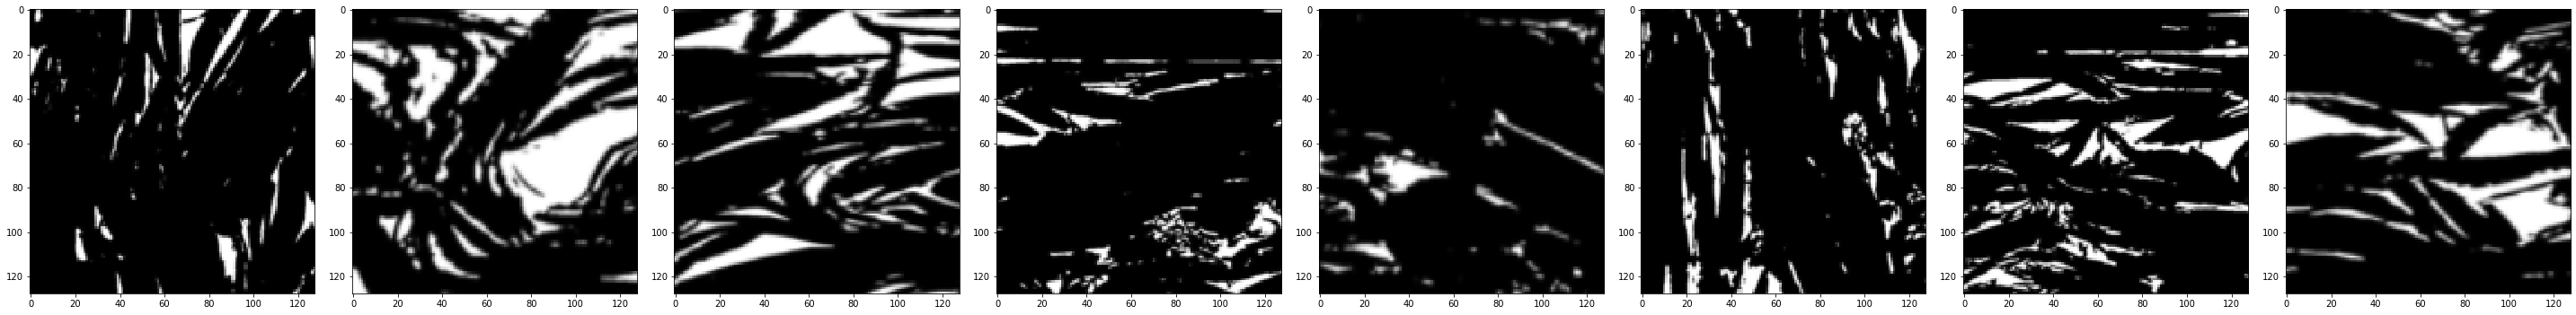

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
fig, axs = plt.subplots(1,8,figsize=(40,5))
plt.tight_layout()

for c in range(8):
 
  img = real_batch[c,::].squeeze()
  # pil_image = Image.fromarray(img)
 
  plt.subplot(1,8,c+1)   
    
  plt.imshow(img, cmap="gray",interpolation='none')


# generator and Discriminator

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Generator(nn.Module):
    def __init__(self, ngpu, image_size):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        if image_size == 64:
            self.main = nn.Sequential(
                # image input size 64x64
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 8),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=False),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=False),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=False),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=False),
                # state size. (ngf) x 32 x 32
                nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
                nn.Tanh()
                # state size. (nc) x 64 x 64
              )
        elif image_size==128:
            self.main = nn.Sequential(               
                # Image input size 128x128
                #input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 16),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf*16) x 4 x 4
                nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf*8) x 8 x 8
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf*4) x 16 x 16 
                nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf*2) x 32 x 32
                nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                # nn.ReLU(True),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf) x 64 x 64
                nn.ConvTranspose2d(ngf,      nc, 4, 2, 1, bias=False),
                nn.Tanh()
                # state size. (nc) x 128 x 128
            )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu, image_size):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        if image_size==64:
            self.main = nn.Sequential(
                # input is (nc) x 64 x 64
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 4 x 4
                nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
        elif image_size==128:
            self.main = nn.Sequential(               
                # input is (nc) x 128 x 128
                nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 64 x 64
                nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 32 x 32
                nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 16 x 16 
                nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 8 x 8
                nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*16) x 4 x 4
                nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                # state size. 1
            )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu, image_size).to(device)
print(netG)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# Print the model



if EvaluationPhase:
    netG.load_state_dict(torch.load(chkPath_netG))
    netG.eval()
    with torch.no_grad():
        noImages = 8
        # Generate batch of latent vectors
        noise = torch.randn(8, nz, 1, 1, device=device)
        # Generate fake image batch with G
        genImages = netG(noise)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Evaluation Images")
        plt.imshow(np.transpose(vutils.make_grid(genImages.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()        
    exit()
    

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)
    
# Create the Discriminator
netD = Discriminator(ngpu, image_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
netD


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvT

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, moment

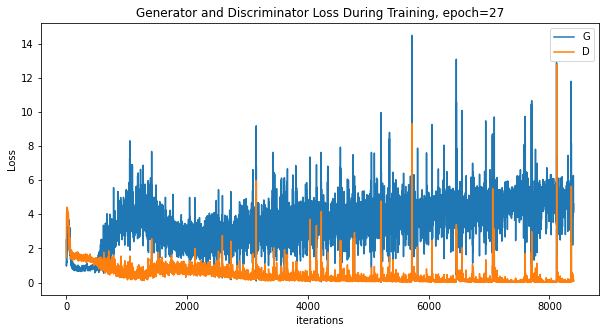

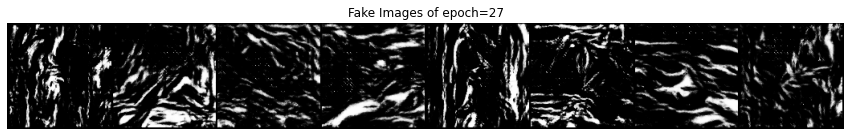

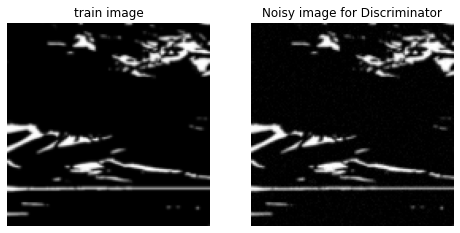

[28/50][0/300]	Loss_D: 0.4917	Loss_G: 2.3098	D(x): 0.7404	D(G(z)): 0.0861 / 0.2501


KeyboardInterrupt: ignored

In [ ]:

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
no_of_images = 8
fixed_noise = torch.randn(no_of_images, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
t = time.time()
# For each epoch
for epoch in range(num_epochs):
    plotNoise = True
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        
        # ***** adding noise to input *******
        if AddNoiseToD:
            mean = 0
            std = STD_ini/(epoch+1) # vanishing std through epochs
            noise  = (torch.randn(real_cpu.shape, device=device) + mean) * std
            # plot for debugging
            if plotNoise:
                plt.figure(figsize=(8,8))
                plt.subplot(1,2,1)
                plt.axis("off")
                plt.title("train image")
                plt.imshow(np.transpose(vutils.make_grid(real_cpu.to(device)[:1], padding=2, normalize=True).cpu(),(1,2,0)))           
            
            real_cpu = noise + real_cpu  
            real_cpu[real_cpu>1] = 1 #normalize data between -1< <1
            real_cpu[real_cpu<-1] = -1
            
            # plot for debugging
            if plotNoise:
                plt.subplot(1,2,2)
                plt.axis("off")
                plt.title("Noisy image for Discriminator")
                plt.imshow(np.transpose(vutils.make_grid(real_cpu.to(device)[:1], padding=2, normalize=True).cpu(),(1,2,0)))
                plt.show()
                plotNoise = False
            
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # print('output=',output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    # plot G_loss and D_loss
    plt.figure(figsize=(10,5))
    plt.title(f'Generator and Discriminator Loss During Training, epoch={epoch}')
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Saving check point model
    torch.save(netG.state_dict(), f'./_results/{datafolderName}_ckp/netG_{datafolderName}_epoch{epoch}.pt')
    torch.save(netD.state_dict(), f'./_results/{datafolderName}_ckp/netD_{datafolderName}_epoch{epoch}.pt')
    
    # Plot the fake images from the current epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.title(f"Fake Images of epoch={epoch}")
    plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
    plt.show()



In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
elapsed = time.time() - t
print('elapsed time=', elapsed, ' sec')

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:no_of_images], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()